# Figure 2. 

This notebook shows how to show the data for figure 2. And how to extract the corresponding values. 

The folder ```TablesForExploration``` can be found [here](https://opendata.earlham.ac.uk/wheat/under_license/toronto/Ramirez-Gonzalez_etal_2018-06025-Transcriptome-Landscape/data/TablesForExploration/)

The first step is to load all the processed information with the function ```loadGeneInformation```

In [1]:
options(gsubfn.engine = "R")
library(ggplot2)
library(reshape2)
library(sqldf)
library(fields)
library(gridExtra)
library(ggtern)
library(clue)
library(geometry)
library(gtable)
#library(goseq)
library(plyr)
library(scales)

loadGeneInformation<-function(dir="../../TablesForExploration", 
                              motifs=T, 
                              WGCNA=F, 
                              meanTpms=T
                             ){
    
    path<-paste0(dir,"/CanonicalTranscript.rds")
    canonicalTranscripts<-readRDS(path)
    canonicalTranscripts$intron_length<- canonicalTranscripts$mrna_length -  canonicalTranscripts$exon_length
    canonicalTranscripts$chr_group <- substr(canonicalTranscripts$Chr,4,4)
    canonicalTranscripts$genome    <- substr(canonicalTranscripts$Chr,5,5)
    expressed_genes <- canonicalTranscripts$Gene
    
    if(meanTpms == T){
        path<-paste0(dir, "/MeanTpms.rds")
        meanTpms <- readRDS(path)
        expressed_genes<-unique(meanTpms$gene)
    }
    
    canonicalTranscripts<-canonicalTranscripts[canonicalTranscripts$Gene %in% expressed_genes, ]
    
    canonicalTranscripts$scaled_5per_position <-   5 * ceiling(canonicalTranscripts$scaled_1per_position / 5)
    canonicalTranscripts$scaled_5per_position <- ifelse(canonicalTranscripts$scaled_5per_position == 0, 
        5, 
        canonicalTranscripts$scaled_5per_position)

    path<-paste0(dir, "/region_partition.csv")
    partition<-read.csv(path, row.names=1)
    
    partition_percentages<-round(100*partition/partition$Length)
    partition_percentages$Chr <- rownames(partition_percentages)
    partition$Chr <- rownames(partition)
    ct<-canonicalTranscripts
    ct_with_partition<-sqldf('SELECT ct.*, CASE 
WHEN scaled_1per_position < R1_R2a THEN "R1"
WHEN scaled_1per_position < R2a_C  THEN "R2A"
WHEN scaled_1per_position < C_R2b  THEN "C"
WHEN scaled_1per_position < R2b_R3  THEN "R2B"
ELSE "R3" END as partition
    
FROM ct LEFT JOIN partition_percentages ON ct.chr = partition_percentages.chr   ')

    x<-  as.factor(ct_with_partition$partition)
    x <- factor(x,levels(x)[c(2,3,1,4,5)])
    ct_with_partition$partition <- x 
    canonicalTranscripts<-ct_with_partition

    path<-paste0(dir,"/TriadMovement.rds")
    triadMovement<-readRDS(path)
    
    path<-paste0(dir,"/Triads.rds")
    triads<-readRDS(path)
    
    path<-paste0(dir,"/universe_table.csv")
    gene_universe<-read.csv(path)
    
    path<-paste0(dir, "/OntologiesForGenes.rds")
    ontologies<-readRDS(path)
    
    path<-paste0(dir, "/id_names_merged.txt")
    id_names <- read.csv(path, header=F, sep = "\t")
    
    if(WGCNA == T){
        path<-paste0(dir, "/WGCNA_table.csv")
        WGCNA <-  read.csv(path)    
    }
    
    path<-paste0(dir, "/ObservedGOTermsWithSlim.csv")
    go_slim<-read.csv(path, row.names=1)

    
    if(motifs == T){
        path<-paste0(dir, "/motifs.rds")
        motifs <- readRDS(path)
        motifs<-unique(motifs)
    }
   
    path<-paste0(dir, "/SegmentalTriads.csv")
    allTriads<-read.csv(path, stringsAsFactors=F)
    only_genes<-allTriads[,c("group_id","A", "B", "D")]
    allTriads<-melt(only_genes, id.vars<-c("group_id"),
        variable.name = "chr_group",
        value.name ="gene")
    
    list(canonicalTranscripts=canonicalTranscripts, 
       meanTpms=meanTpms,
       triads=triads, 
       triadMovement=triadMovement,
       gene_universe=gene_universe, 
       ontologies=ontologies,
       id_names=id_names,
       WGCNA=WGCNA,
       GOSlim=go_slim,
       partition=partition,
       motifs=motifs,
       allTriads=allTriads
       )
}


folder<-"../TablesForExploration"


geneInformation<-loadGeneInformation(dir=folder,motifs=F,meanTpms=T)





Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite
Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-1 (2018-12-20) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 
--
Remember to cite, run citation(package = 'ggtern') for further info.
--

Attaching package: ‘ggtern’

The following objects are masked from ‘package:gridExtra’:

    arrangeGrob, grid.arrange

The following objects are masked from ‘package:ggplot2’:

    %+%, aes, annotate, calc_element, ggplot, ggplot_build,
    ggplot

## Datasets

For different analysis we prepared the analysis on different sample groups, including only the `High Confidence (HC)` genes. 

1. **HC_Development**. Development course of Azhurnaya
2. **HC_850_samples**. All the samples used in the metastudy. 
3. **HC_CS_no_stress**. Chinese Spring, excluding stressed. 
4. **HC_CS_NB_inc_stress**. All Chinese Spring samples, inclduing stressed samples. 
5. **HC_abiotic**. Samples with abiotic stress, excluding the corresponding controls. 
6. **HC_disease**. Samples with biotic stress, excluding the corresponding controls. 
7. **HC_grain**. Grain samples.
8. **HC_leaf**. Leaf samples.
9. **HC_root**. Root samples. 
10. **HC_spike**. Spike samples. 
11. **HC_abiotic_merged_control**. Abiotic stress, with all the controlls taken as a single replicate group.
12. **HC_disease_merged_control**. Bbiotic stress, with all the controlls taken as a single replicate group.
13. **HC_stress_control** All the controlls of the stressed samples 
14. **HC_abiotic_stress_control** Controls for the samples with abiotic stress. 
15. **HC_disease_stress_control** Controls for the samples with biotic stress.
16. **HC_abiotic_stress** Samples with abiotic stress, including the corresponding controls
17. **HC_disease_stress**  Samples with biotic stress, including the corresponding controls.
18. **HC_stress** All the samples with stress

The details of which samples are included in dataset are in the ```metadata.csv``` file. 

The following functions to define the ```experiment``` in the following functions. 

## Extract the average expression balance. 

The tables include all the averaged expression under each one of the experiments. The function ```getAverageTriad``` gets the table for the corresponding dataset. 

In [2]:
getAverageTriad <-function(geneInformation, experiment='HC_CS_no_stress'){
    gu<-geneInformation$gene_universe
    genes_to_plot<-gu[gu$dataset==experiment,"gene"]
    allTriads<-geneInformation$allTriads
    selectedTriads<-unique(allTriads[allTriads$gene %in% genes_to_plot, "group_id"])
    tmp_df<-geneInformation$triads[geneInformation$triads$group_id %in% selectedTriads &
                                  geneInformation$triads$dataset == experiment,
                                   c("group_id","factor","clust","description","general_description","chr_group","normalised_triad", "Distance")]
    
    clust_df <- dcast(tmp_df,
                      group_id + clust + description + 
                      general_description + factor + Distance ~ 
                      chr_group,
                      value.var = "normalised_triad"
                     )
    
    clust_df <- clust_df[clust_df$factor  == 'all_mean_filter' , ]
    clust_df$experiment=experiment
    clust_df
}

dev_triads<-getAverageTriad(geneInformation, experiment = "HC_Development")
cs_triads<-getAverageTriad(geneInformation, experiment = "HC_CS_no_stress")
write.csv(dev_triads, file=gzfile("azhurnaya_average_movement.csv.gz"), row.names =F)
write.csv(cs_triads, file=gzfile("ChinesseSpring_average_movement.csv.gz"), row.names =F)

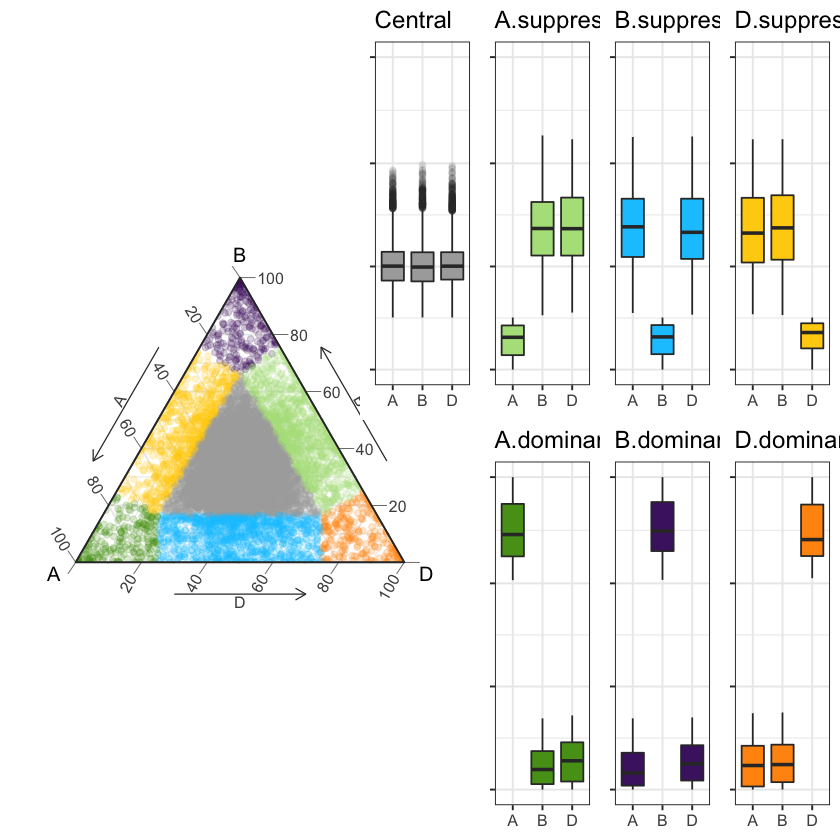

In [3]:
get_legend<-function(myggplot){
  tmp <- ggplot_gtable(ggplot_build(myggplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}
group.colors<-c(A.dominant = "#579D1C", B.dominant = "#4B1F6F", D.dominant ="#FF950E", 
             Central="#AAAAAA",Balanced="#AAAAAA", 
             A.suppressed = "#b2E08a", B.suppressed = "#0eC7ff", D.suppressed ="#ffCF0e")
chr.colors<-c(A = "#579D1C", B = "#4B1F6F", D ="#FF950E")
                      
plot_panel_2A<-function(geneInformation,
                          genes_to_plot, 
                          experiment="HC_850_samples",
                          group.colors=c(A.dominant = "#579D1C", B.dominant = "#4B1F6F", D.dominant ="#FF950E", 
             Central="#AAAAAA", 
             A.suppressed = "#b2E08a", B.suppressed = "#0eC7ff", D.suppressed ="#ffCF0e"),
                        chr.colors = c(A = "#579D1C", B = "#4B1F6F", D ="#FF950E"),
                        color_by_chromosome=FALSE,
                        color_by_category=TRUE,
                        only_highlight_color=FALSE
                        
                        ){
    
    allTriads<-geneInformation$allTriads
    selectedTriads<-unique(allTriads[allTriads$gene %in% genes_to_plot, "group_id"])
    
    tmp_df<-geneInformation$triads[geneInformation$triads$group_id %in% selectedTriads &
                                  geneInformation$triads$dataset == experiment,
                                   c("group_id","factor","clust","description","general_description","chr_group","normalised_triad", "Distance")]
    
    clust_df <- dcast(tmp_df,
                      group_id + clust + description + 
                      general_description + factor + Distance ~ 
                      chr_group,
                      value.var = "normalised_triad"
                     )
    
    clust_df <- clust_df[clust_df$factor  == 'all_mean_filter' , ]
    
    
    
    
    
    group.alpha<-c(A.dominant = 0.2, B.dominant = 0.2, D.dominant =0.2, 
             Central=0.2, 
             A.suppressed = 0.2, B.suppressed = 0.2, D.suppressed = 0.2)
    
    tern_mean <- ggtern(clust_df,aes(A,B,D,color=description)) +  theme_bw() +
        theme_legend_position(x = "topleft")  + 
    scale_color_manual(values=group.colors) +
       theme_arrownormal()

    tern_mean <- tern_mean +  geom_point(aes(alpha=description)) + scale_alpha_manual(values=group.alpha)
    tern_mean <- tern_mean + guides(colour = guide_legend(override.aes = list(alpha = 1)))
    #tern_leg<-get_legend(tern_mean)
    
    tern_mean <- tern_mean + theme(legend.position="none")

    tern_mean <- tern_mean + theme(tern.axis.ticks.length.major = unit(0.6, "cm"))
    gs<-list(tern_mean)
    clusters<-c("Central",
                "A.suppressed", "B.suppressed","D.suppressed",
                "A.dominant"  , "B.dominant"  ,"D.dominant")
    tmp_df<-clust_df[,c("A","B","D","group_id","clust","description")]
    tmp_df<-melt(tmp_df,id=c("group_id","clust","description"))
    colnames(tmp_df)<-c("group_id","clust","description","chr_group","normalised_triad")

    for(clust in clusters){
        tmp_df_clust<-tmp_df[tmp_df$description==clust,]
        fill_by<-NULL
        local_colors<-c("#FFFFFF")
        if(color_by_category){
            fill_by<-"description"
            local_colors<-group.colors
        }
        if(color_by_chromosome){
           fill_by<-"chr_group" 
           local_colors<-chr.colors
        }
        p <- ggplot(tmp_df_clust, aes_string("chr_group", "normalised_triad", fill=fill_by))
        p <- p + geom_boxplot(outlier.alpha = 0.05) 
     
        p <- p + scale_fill_manual(values=local_colors)
        p <- p + scale_y_continuous( breaks=c(0, 0.33, 0.66,1) )
        
        p <- p + theme_bw()
        p <- p + ylab("") + xlab("")
        p <- p + ggtitle(clust) + guides(fill=FALSE)
        p <- p + theme(axis.title.y=element_blank(),
                       axis.text.y=element_blank(),
                       axis.title.x=element_blank())
        p <- p + coord_cartesian(ylim = c(0,1))
        
        gs[[length(gs)+1]] <- p
    }
    
    #gs[[length(gs)+1]] <- tern_leg
    
    lay <- rbind(c( 1, 1, 1, 2, 3, 4, 5),
                 c( 1, 1, 1, 1, 6, 7, 8)
                 )

    g2 <- arrangeGrob(grobs = gs, layout_matrix = lay)
    g2
}
gu<-geneInformation$gene_universe
genes_to_plot<-gu[gu$dataset=="HC_CS_no_stress","gene"]                      
p<-plot_panel_2A(geneInformation,
                 genes_to_plot,
                experiment="HC_CS_no_stress")
grid.draw(p)


**Fig. 2. Homeolog expression bias in syntenic homoeolog triads.  (A)** Ternary plot showing relative expression abundance of 16,746 gene triads (50,238 genes) in hexaploid wheat in the 15 tissues combined analysis. Each circle represents a gene triad with an A, B, D coordinate consisting of the relative contribution of each homoeolog to the overall triad expression. Triads in vertices correspond to single genome dominant categories, whereas triads close to edges and between vertices correspond to suppressed categories. Central triads (light blue) correspond to those with balanced expression across the global analysis. Boxplots of the relative contribution of each genome based on triad assignment to the seven categories.

### Categories for each gene

To get the movment category for each gene, the function ```get_triad_values``` can be used. The columns areL

 * **gene** 
 * **group_id** The internal ID of the triad. 
 * **factor** The tissues. ```all_means_filter``` is the average used for Fig2A. 
 * **clust** The ID of the category
 * **description** Description of the movement category
 * **general_description** The general description of the movment category. 
 * **chr_group** The A, B or D genome where the gene corresponds.
 * **normalised_triad** The normalised expression value
 * **Distance** The distance to the selected category. 

In [15]:
get_triad_values<-function(geneInformation, experiment='HC_CS_no_stress'){
    gu<-geneInformation$gene_universe
    genes_to_plot<-gu[gu$dataset==experiment,"gene"]
    allTriads<-geneInformation$allTriads
    selectedTriads<-unique(allTriads[allTriads$gene %in% genes_to_plot, "group_id"])
    tmp_df<-geneInformation$triads[geneInformation$triads$group_id %in% selectedTriads &
                                  geneInformation$triads$dataset == experiment,
                                   c("group_id","factor","clust","description","general_description","chr_group","normalised_triad", "Distance")]
    tmp_df2<-sqldf("SELECT allTriads.gene, tmp_df.* FROM tmp_df 
JOIN allTriads ON 
    allTriads.group_id = tmp_df.group_id AND
 allTriads.chr_group = tmp_df.chr_group
")
    tmp_df2
}

dev_triads<-get_triad_values(geneInformation, experiment = "HC_Development")
head(dev_triads)
cs_triads<-get_triad_values(geneInformation, experiment = "HC_CS_no_stress")
write.csv(dev_triads, file=gzfile("azhurnaya_tissues_movement.csv.gz"), row.names =F)
write.csv(cs_triads, file=gzfile("ChinesseSpring_tissues_average_movement.csv.gz"), row.names =F)

gene,group_id,factor,clust,description,general_description,chr_group,normalised_triad,Distance
TraesCS7A01G185200,263,roots,6,B.suppressed,Suppressed,A,0.5671713,0.40938246
TraesCS7B01G090200,263,roots,6,B.suppressed,Suppressed,B,0.0000000,0.40938246
TraesCS7D01G186600,263,roots,6,B.suppressed,Suppressed,D,0.4328287,0.40938246
TraesCS7A01G542500,293,roots,1,Central,Central,A,0.3630821,0.08591908
TraesCS7B01G464400,293,roots,1,Central,Central,B,0.3569187,0.08591908
TraesCS7D01G527700,293,roots,1,Central,Central,D,0.2799993,0.08591908


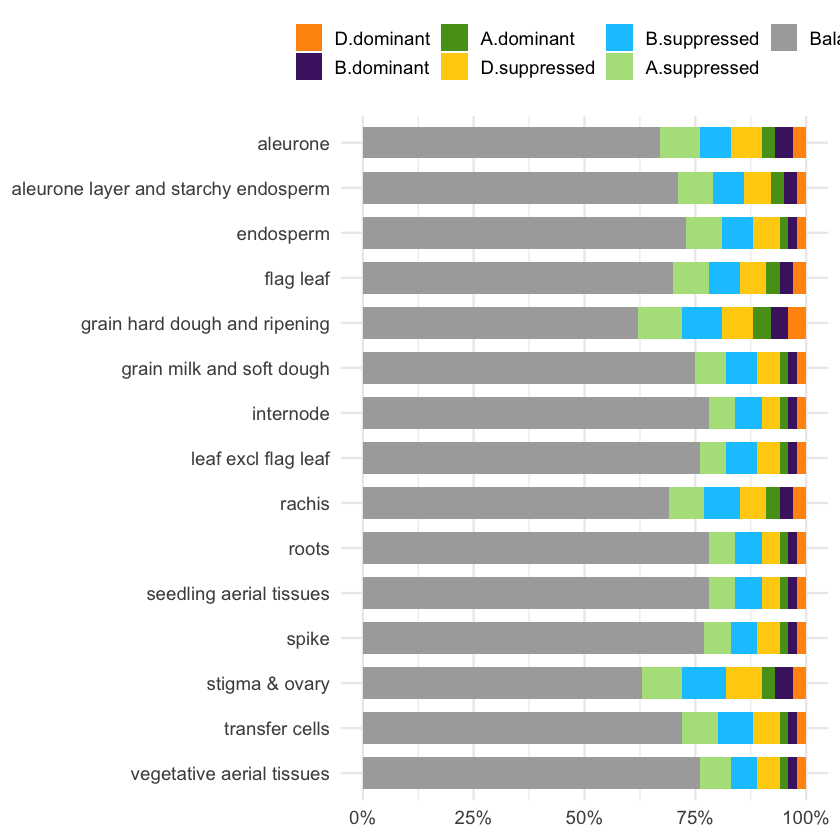

In [8]:
plot_panel_2B<-function(filename="./percentage_of_triads_asigned_per_tissue.csv",
                       group.colors=c(A.dominant = "#579D1C", B.dominant = "#4B1F6F", D.dominant ="#FF950E", 
             Central="#AAAAAA", 
             A.suppressed = "#b2E08a", B.suppressed = "#0eC7ff", D.suppressed ="#ffCF0e")){
    table <- read.csv(filename)
    melted_data<-melt(table, id.vars = c("Tissue"), variable.name =  "category")
    brks <- c(0, 0.25, 0.5, 0.75, 1)
    
    
    tissue_factors<- c("aleurone","aleurone layer and starchy endosperm","endosperm","flag leaf",
                       "grain hard dough and ripening", "grain milk and soft dough", "internode",
                       "leaf excl flag leaf", "rachis", "roots", "seedling aerial tissues", "spike",
                       "stigma & ovary", "transfer cells", "vegetative aerial tissues")
    
    tissue_factors<-rev(tissue_factors)
    melted_data$Tissue = factor( melted_data$Tissue,levels = tissue_factors)
    
    category_factors <- c("D.dominant","B.dominant","A.dominant",
                          "D.suppressed", "B.suppressed", "A.suppressed",
                         "Balanced")
    melted_data$category = factor( melted_data$category,levels = category_factors)


    p<-ggplot(melted_data, aes(x = factor(Tissue), y = value, fill = factor(category))) +
    geom_bar(stat="identity", width = 0.7) +
    scale_y_continuous(breaks = brks, labels = scales::percent(brks)) +
    labs(x = NULL, y = NULL, fill = NULL) +
    theme_minimal(base_size = 14)
    p <- p + coord_flip()
    p <- p + scale_fill_manual(values=group.colors)
    p <- p + theme(legend.position = "top", 
                   legend.direction = "horizontal")
    p
}
p<-plot_panel_2B(group.colors=group.colors)
p


**(B)** Proportion of triads in each homoeolog expression bias category across the 15 tissues and the average across tissues. 

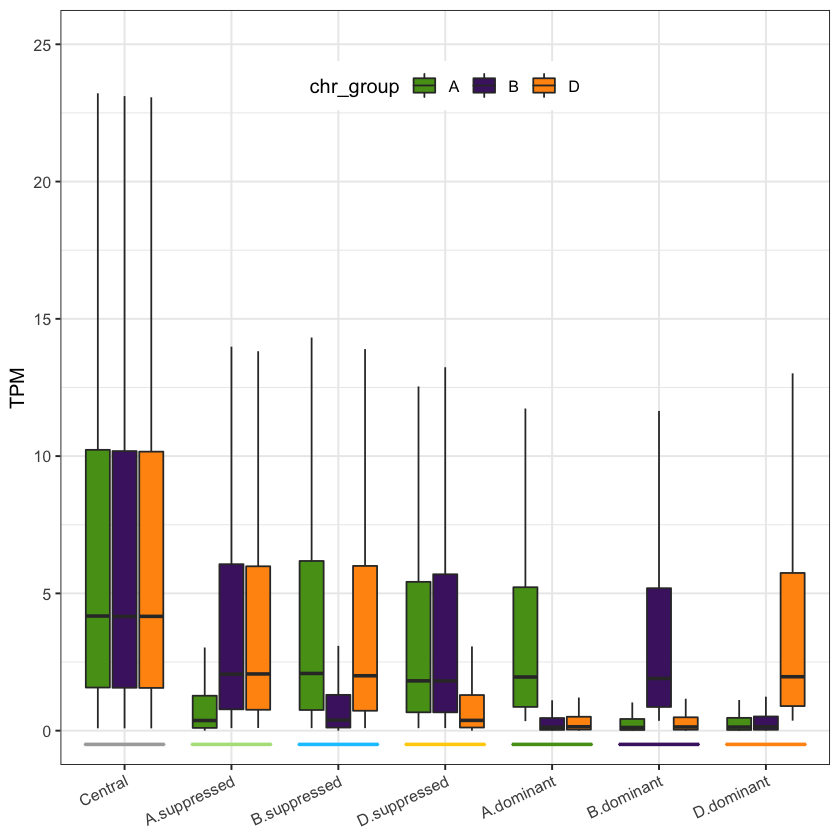

In [5]:
plot_panel_2C<-function(geneInformation, 
                        dataset="HC_CS_no_stress", 
                        chr.colors = c(A = "#579D1C", 
                                        B = "#4B1F6F", 
                                        D ="#FF950E"),
                       min_factor_count=5,
                       group.colors=c(A.dominant = "#579D1C", B.dominant = "#4B1F6F", D.dominant ="#FF950E", 
             Central="#AAAAAA", 
             A.suppressed = "#b2E08a", B.suppressed = "#0eC7ff", D.suppressed ="#ffCF0e")){
    tm<-geneInformation$triadMovement
    tm<-tm[tm$dataset == dataset &
           tm$factor_count > min_factor_count,
           c("group_id", "category", "sum_mean_tpm", "factor_count")]
    triads<-geneInformation$triads
    triads<-triads[triads$dataset==dataset, c("group_id",
                                              "chr_group",
                                              "description", 
                                              "value")]
    
    category_factors <- c("Central","A.suppressed", "B.suppressed","D.suppressed",
                          "A.dominant","B.dominant","D.dominant"
                            
                         )
    somelines <- data.frame(value=c(-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5),
                            boxplot.nr=factor(category_factors,
                                              levels=category_factors) )

    
    triads$description = factor( triads$description,levels = category_factors)
    p <- ggplot(triads, aes(description, 
                            value,
                            fill=chr_group)) 
    p <- p + geom_boxplot(outlier.shape=NA) 
    p <- p + scale_fill_manual(values=chr.colors) 
    p <- p + coord_cartesian(ylim = c(0,25))
    p <- p + theme_bw()
    #p <- p + guides(fill=FALSE)
    p <- p + xlab(NULL) + ylab("TPM")
    p <- p + theme(axis.text.x = element_text(angle = 25, hjust = 1)) 
    p <- p + geom_boxplot(data=somelines,aes(boxplot.nr,value, 
                                             color=boxplot.nr),
                          inherit.aes=FALSE,size=0.5) 
    p <- p + scale_color_manual(values= group.colors)
    p <- p + guides(color=FALSE)
    p <- p + theme(legend.position = "bottom", 
                   legend.direction = "horizontal")
    p <- p + theme(legend.position = c(0.5, 0.9))
    p
}

p<-plot_panel_2C(geneInformation, chr.colors=chr.colors, group.colors=group.colors)
p

**(C)** Boxplot of absolute TPM expression abundance for each genome based on the seven categories. 

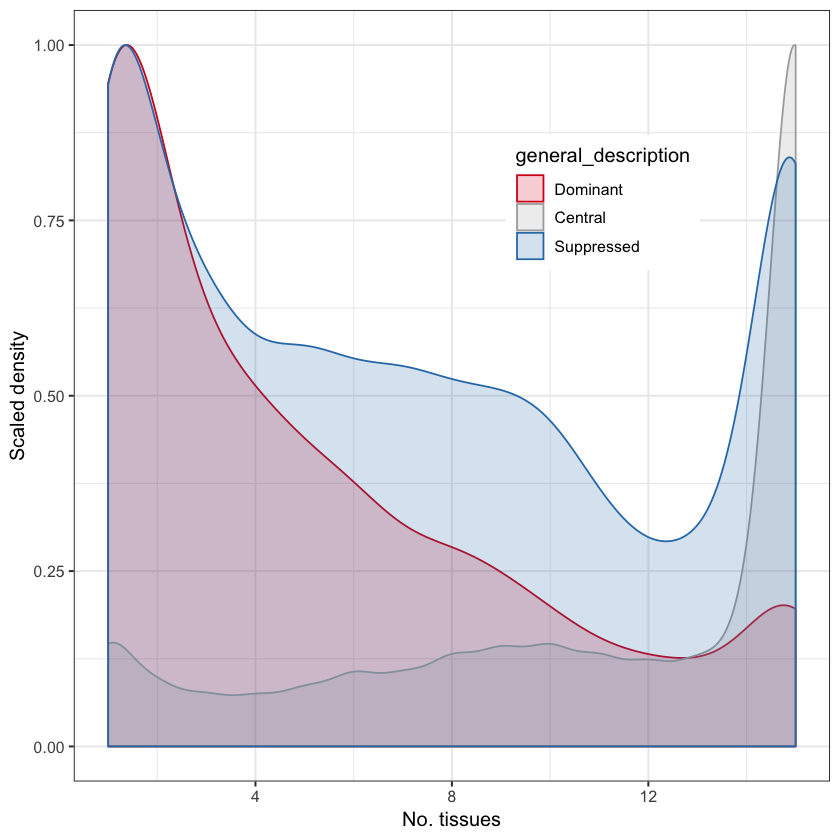

In [4]:
plot_panel_2d <- function(geneInformation,
                                  gene_sets=list(),
                                  experiment="CS_no_stress",
                                  min_tpm=0.5,
                                  title="Test"){
    
    tpms <- geneInformation$meanTpms
    local_title <- paste0(title, "\n", experiment)
    tpms<-tpms[tpms$subset == experiment & 
        tpms$factor == "all_mean_filter"& 
        tpms$value > min_tpm,  ]
        triads<-geneInformation$triads

    triads<-triads[triads$factor == "all_mean_filter" &
                   triads$datase == paste0("HC_", experiment),
                   c("gene", "factor", "general_description")]
     
     local_tpms<-sqldf("SELECT tpms.*,triads.general_description 
FROM tpms JOIN triads ON triads.gene=tpms.gene")
    
    breaks <- seq(-1,max(local_tpms$samples) , by = 1)
    samples.cut <- cut(local_tpms$samples, breaks, include.lowest = FALSE)
    samples.freq <- table(samples.cut)
    cumfreq0 =  cumsum(samples.freq)
   
    level <- ifelse(local_tpms$value < 0.1, 0.1, local_tpms$value) 
    level <- ceiling(log10(level))
    level <- ifelse(level > 2, 2, level )
    local_tpms$level <- level
    local_tpms$exp_max_value <- as.factor(10**level)
    
    category_factors <- c("Dominant", "Central", "Suppressed")
    local_tpms$general_description = factor( local_tpms$general_description,levels = category_factors)
    
    
    g <- ggplot(local_tpms)
    g <- g + geom_density(aes(x=samples, y =   ..scaled..,
                              fill=general_description, color=general_description), 
                          alpha=0.2)
    
    g <- g + scale_fill_manual (values=c(Central="#AAAAAA", Dominant="#d7191c", Suppressed="#2c7bb6"))  
    g <- g + scale_color_manual(values=c(Central="#AAAAAA", Dominant="#d7191c", Suppressed="#2c7bb6"))
     
    g <- g + theme_bw() 
    g <- g + ylab("Scaled density")
    g <- g + xlab("No. tissues")
    #g <- g + theme(legend.position = "bottom", 
    #               legend.direction = "horizontal")
    g <- g + theme(legend.position = c(0.7, 0.75))
    g
}

g<-plot_panel_2d(geneInformation)
g


**(D)** Number of tissues in which homoeolog-suppressed (green), homeolog-dominant (blue) and central (red) triads are expressed. 